In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from attr.validators import max_len
from keras.src.layers import TextVectorization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from joblib import parallel_backend

2024-11-25 00:02:55.506772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732521775.528402   23394 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732521775.534887   23394 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 00:02:55.558528: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load in the data 

promoters = pd.read_csv('Data/promoter.csv')
promoters.columns = ['Sequence']
non_promoters = pd.read_csv('Data/non_promoter.csv')
non_promoters.columns = ['Sequence']
label_vector = np.ones(promoters.shape[0]).tolist() + np.zeros(non_promoters.shape[0]).tolist()
combined_data = pd.concat([promoters, non_promoters], axis=0)

In [4]:
# train test validation split
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    combined_data, label_vector, test_size=0.2, stratify=label_vector, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, stratify=y_train_val, random_state=42
)  # 0.125 because 0.125 * 80% = 10%

# Check the sizes
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 42000
Validation size: 6000
Test size: 12000


In [5]:
y_train = np.array(y_train)
print(X_train)
print(y_train)

                                                Sequence
8648   TGGCAAGGGGCCGTGGAGCCTGTAAGACTATCCCCCCAGCCACCCA...
27325  AATATGTAGGCAGTTTTCTTTGCTTTGACATGGAAGCAGTTTTAAC...
24871  TCCGCAGCTGGTGTCCTTCAACAAAAGTAATCACCTCTCTCCCCGG...
16509  TTCCCTGTTCTTCACAATCTGTGAGCACTGTAATGTTACACTTCAA...
12014  ACTAGGTCCTTCTTCCCCATGTTTTATACAGACGGACCAGAAGCCA...
...                                                  ...
17648  AATGAATATGTTGGAAATTATATGCAAATTGGCTTCCGTTGGTGTT...
28299  CACAGGCTTACAGGTACAGTCAGCGGACCCAGCCTGGGCTGGATCT...
14293  CCATCTCTGAGATATGTGGTCTTGACCTCCCAGCATGAAGTGTGCA...
27224  TCCGCTGAACTATTGCCCCCGACGGGCTTTGTTCGAAGACAATCAC...
14640  AGTGACATCGAGATGGGCTCTTTTCACCCCCCTCCCCCACTGCTCT...

[42000 rows x 1 columns]
[1. 0. 1. ... 0. 1. 0.]


In [53]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
import numpy as np

class KmerVectorizer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to vectorize k-mers for different K values.
    """
    def __init__(self, K=3):
        self.K = K
        self.vectorizer = None

    def fit(self, X, y=None):
        self.vectorizer = CountVectorizer(analyzer='char', ngram_range=(self.K, self.K))
        self.vectorizer.fit(X)
        return self

    def transform(self, X):
        return self.vectorizer.transform(X)


def evaluate_model(best_model, X_test, y_test, model_name, attention=False, max_length=None):
    """
    Evaluate a model on the test set and generate metrics including ROC curves.

    Parameters:
    - best_model: The trained model to evaluate.
    - X_test: Test data (features).
    - y_test: Test labels.
    - model_name: Name of the model for saving results.

    Returns:
    - metrics: Dictionary of evaluation metrics.
    """
    print(f"Evaluating {model_name} on test data...")

    # Check if model is a Keras model
    if isinstance(best_model, tf.keras.Model):
        # Convert X_test to a tf.Tensor with dtype=tf.string
        if not attention:
            X_test_tensor = tf.constant(X_test, dtype=tf.string)
        else:
            X_test_tokenized, _ = tokenize_sequences(X_test, max_length)
            X_test_tensor = tf.constant(X_test_tokenized, dtype=tf.int32)
        # Get predicted probabilities
        y_prob = best_model.predict(X_test_tensor).flatten()
        y_prob = y_prob.astype(np.float64)
        # Convert probabilities to class labels
        y_pred = (y_prob >= 0.5).astype(int)
    else:
        # For scikit-learn models
        y_pred = best_model.predict(X_test)
        if hasattr(best_model, "predict_proba"):
            y_prob = best_model.predict_proba(X_test)[:, 1]
        else:
            y_prob = None

    # Compute metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
    }

    # Generate ROC curve if probabilities are available
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        metrics['roc_auc'] = roc_auc

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"ROC Curve for {model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.savefig(f"{model_name}_roc_curve.png")
        plt.close()
        print(f"ROC curve saved as '{model_name}_roc_curve.png'")
    else:
        print("Predicted probabilities are not available; ROC curve cannot be generated.")

    return metrics

def gridsearch_with_logging(X_train, y_train, model, param_grid, model_name, cv=5, scoring='accuracy', max_cpu_fraction=0.7, transform=True):
    """
    Perform grid search with cross-validation, tracking progress and logging results, while limiting resource usage.

    Parameters:
    - X_train: Training data (features).
    - y_train: Training labels.
    - model: sklearn model.
    - param_grid: Parameter grid for grid search.
    - model_name: Name of the model for saving/loading files.
    - cv: Number of cross-validation folds.
    - scoring: Scoring metric.
    - max_cpu_fraction: Fraction of available CPU resources to use.

    Returns:
    - best_model: Trained pipeline with the best parameters.
    - best_params: Best parameter set.
    - best_score: Best cross-validation score.
    """
    # Check if the model is already trained
    model_file = f'best_{model_name}_model.pkl'
    log_file = f'{model_name}_gridsearch_log.csv'

    if os.path.exists(model_file):
        print(f"Model '{model_file}' already exists. Loading the model...")
        best_model = joblib.load(model_file)
        return best_model, None, None

    # Create pipeline
    if transform:
        pipeline = Pipeline([
            ('kmer', KmerVectorizer()),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('model', model)
        ])
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,# Will be controlled by `parallel_backend`
        verbose= 4
    )

    # Custom callback for progress tracking
    current_combination = 0

    # Start grid search with resource constraints
    print(f"Starting grid search for {model_name} with up to {max_cpu_fraction * 100:.0f}% CPU usage...")

    with parallel_backend('loky', n_jobs=int(max_cpu_fraction * os.cpu_count())):
        grid_search.fit(X_train, y_train)

        # Save log
    results = pd.DataFrame(grid_search.cv_results_)
    results.to_csv(log_file, index=False)

    # Get the best model and save it
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_file)
    print(f"Best model saved as '{model_file}'")

    return best_model, grid_search.best_params_, grid_search.best_score_



0 0
1 0
2 0
0 1
1 1
2 1


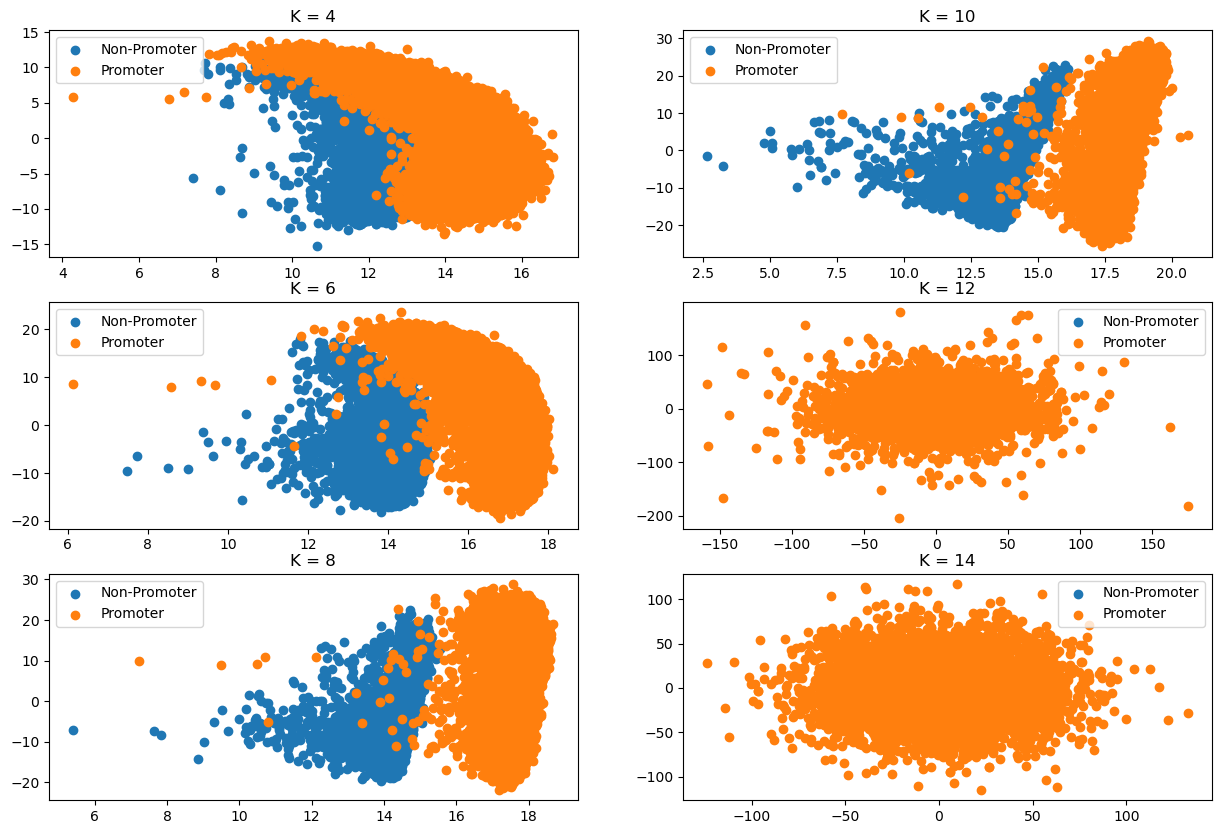

In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
for i, K in enumerate([4, 6, 8, 10, 12, 14]):
    # Create pipeline
    svd_pipeline = Pipeline([
        ('kmer', KmerVectorizer(K=K)),
        ('scaler', StandardScaler(with_mean=False)),
        ('pca', TruncatedSVD(n_components=2))
    ])

    # Fit and transform the data
    X_pca = svd_pipeline.fit_transform(X_train['Sequence'].values)

    # Plot the data
    j = i // 3
    i = i % 3
    print(i, j)
    ax[i, j].scatter(X_pca[y_train == 0, 0], X_pca[y_train == 0, 1], label='Non-Promoter')
    ax[i, j].scatter(X_pca[y_train == 1, 0], X_pca[y_train == 1, 1], label='Promoter')
    ax[i, j].set_title(f"K = {K}")
    ax[i, j].legend()


In [14]:
# training Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
print(f"X_train shape: {len(X_train)}")
print(f"y_train shape: {len(y_train)}")
nb_model = MultinomialNB()
nb_param_grid = {
    'kmer__K': [4, 6, 8, 10],
    'model__alpha': [0.1, 0.5, 1.0],
}
best_nb_model, best_nb_params, best_nb_score = gridsearch_with_logging(
    X_train['Sequence'].values, y_train, nb_model, nb_param_grid, 'naive_bayes'
)
# displaying the best parameters and score
print("Best Parameters:", best_nb_params)


X_train shape: 42000
y_train shape: 42000
Model 'best_naive_bayes_model.pkl' already exists. Loading the model...
Best Parameters: None


/home/alex/anaconda3/envs/PromoterKmers/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/alex/anaconda3/envs/PromoterKmers/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.0.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/alex/anaconda3/envs/PromoterKmers/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline 

In [15]:
# evaluating the model
print(best_nb_params)
nb_metrics = evaluate_model(best_nb_model, X_test['Sequence'].values, y_test, 'naive_bayes')
print(nb_metrics)

None
Evaluating naive_bayes on test data...
ROC curve saved as 'naive_bayes_roc_curve.png'
{'accuracy': 0.83925, 'precision': 0.8749309265058022, 'recall': 0.7916666666666666, 'f1': 0.8312188292939015, 'roc_auc': 0.896454875}


In [16]:
# training Random Forest model
# Define the Random Forest model and parameter grid
model = RandomForestClassifier(random_state=42)
param_grid = {
    'kmer__K': [4, 6, 8, 10,],  # Different k-mer sizes
    'model__n_estimators': [50, 100, 200],  # Number of trees
    'model__max_depth': [10, 20, 50, 100],  # Maximum depth of the trees
    'model__min_samples_split': [2],  # Minimum samples required to split an internal node
}

# Perform grid search with logging
best_rf_model, best_rf_params, best_rf_score = gridsearch_with_logging(
    X_train=X_train['Sequence'].values,
    y_train=y_train,
    model=model,
    param_grid=param_grid,
    model_name='random_forest',
    cv=5,
    scoring='accuracy'
)

Starting grid search for random_forest with up to 70% CPU usage...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 4/5] END kmer__K=6, model__max_depth=20, model__min_samples_split=2, model__n_estimators=50;, score=(train=0.916, test=0.867) total time=15.2min
[CV 2/5] END kmer__K=8, model__max_depth=100, model__min_samples_split=2, model__n_estimators=50;, score=(train=0.932, test=0.861) total time=19.5min
[CV 5/5] END kmer__K=6, model__max_depth=10, model__min_samples_split=2, model__n_estimators=200;, score=(train=0.843, test=0.830) total time= 8.9min
[CV 4/5] END kmer__K=8, model__max_depth=50, model__min_samples_split=2, model__n_estimators=100;, score=(train=0.885, test=0.837) total time=22.5min
[CV 5/5] END kmer__K=6, model__max_depth=20, model__min_samples_split=2, model__n_estimators=200;, score=(train=0.916, test=0.867) total time=40.0min
[CV 5/5] END kmer__K=4, model__max_depth=100, model__min_samples_split=2, model__n_estimators=100;, score=(train=1.000, te

/home/alex/anaconda3/envs/PromoterKmers/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best model saved as 'best_random_forest_model.pkl'


In [8]:
# Display the best parameters and score
print("Best Parameters:", best_rf_params)
rf_metrics = evaluate_model(best_rf_model, X_test['Sequence'].values, y_test, 'random_forest')
print(rf_metrics)

NameError: name 'best_rf_params' is not defined

# The SVM model takes to long to train with k-mer size of 10, we will use SVD to reduce the dimensionality of k-mer size of 10 vectors

In [10]:
svd_pipeline = Pipeline([
    ('kmer', KmerVectorizer(K=10)),
    ('scaler', StandardScaler(with_mean=False)),
    ('pca', TruncatedSVD(n_components=10))
])
full_data_reduced = svd_pipeline.fit_transform(combined_data['Sequence'].values)
reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test = train_test_split(
    full_data_reduced, label_vector, test_size=0.2, stratify=label_vector, random_state=42
)
reduced_X_train, reduced_X_val, reduced_y_train, reduced_y_val = train_test_split(reduced_X_train, reduced_y_train, test_size=0.125, stratify=reduced_y_train, random_state=42)


In [15]:
# training SVM model
from sklearn.svm import SVC
model = SVC(probability=True)
param_grid = {
    'model__C': [0.1, 1, 10],
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['linear', 'rbf'],
}

best_svm_model, best_svm_params, best_svm_score = gridsearch_with_logging(
    X_train=reduced_X_train,
    y_train=reduced_y_train,
    model=model,
    param_grid=param_grid,
    model_name='svm',
    cv=5,
    scoring='accuracy',
    transform=False
)


Starting grid search for svm with up to 70% CPU usage...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END model__C=1, model__gamma=scale, model__kernel=rbf;, score=(train=0.997, test=0.997) total time= 1.9min
[CV 2/5] END model__C=10, model__gamma=scale, model__kernel=rbf;, score=(train=0.999, test=0.998) total time= 2.2min
[CV 4/5] END model__C=1, model__gamma=scale, model__kernel=rbf;, score=(train=0.997, test=0.998) total time= 2.3min
[CV 5/5] END model__C=0.1, model__gamma=auto, model__kernel=linear;, score=(train=0.999, test=0.998) total time= 2.5min
[CV 5/5] END model__C=0.1, model__gamma=scale, model__kernel=linear;, score=(train=0.999, test=0.998) total time= 2.5min
[CV 1/5] END model__C=10, model__gamma=scale, model__kernel=rbf;, score=(train=0.999, test=0.998) total time= 2.4min
[CV 1/5] END model__C=10, model__gamma=scale, model__kernel=poly;, score=(train=0.999, test=0.998) total time= 2.5min
[CV 2/5] END model__C=0.1, model__gamma=scale, model__ker

KeyboardInterrupt: 

In [9]:
print("Best Parameters:", best_svm_params)
svm_metrics = evaluate_model(best_svm_model, reduced_X_test, y_test, 'svm')
print(svm_metrics)

NameError: name 'best_svm_params' is not defined

In [38]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Lambda
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



def create_kmer_model_with_transform(X_train_sequences, k=4, hidden_nodes=128, dropout_rate=0.2):
    # Convert the sequences to tf.string tensors
    X_train_sequences = tf.constant(X_train_sequences, dtype=tf.string)

    text_vectorization = TextVectorization(
        standardize=None,
        split='character',
        ngrams=k,
        output_mode='count',
    )
    # Adapt the layer using a tf.data.Dataset
    text_vectorization.adapt(tf.data.Dataset.from_tensor_slices(X_train_sequences).batch(32))

    # Build the model
    model = Sequential([
        text_vectorization,
        Lambda(lambda x: tf.cast(x, tf.float32)),  # Cast counts to float32
        Dense(hidden_nodes, activation='relu'),
        Dropout(dropout_rate),
        Dense(hidden_nodes // 2, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model





In [31]:
y_train_tensor = tf.constant(y_train)
y_val_tensor = tf.constant(y_val)
train_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X_train['Sequence'].values, dtype=tf.string),y_train_tensor)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X_val['Sequence'].values, dtype=tf.string), y_val_tensor)).batch(32)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)


Creating Kmer models for various K values

In [40]:


k_values = [4, 6, 8, 10]
kmer_models = []
kmer_model_names = []

for k in k_values:
    model_name = f'k_{k}'
    print(f"Training model {model_name}...")
    model = create_kmer_model_with_transform(X_train['Sequence'].values, k=k, hidden_nodes=256, dropout_rate=0.2)
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )
    model_checkpoint = ModelCheckpoint(
        filepath=f'{model_name}_best_model.keras',
        monitor='val_loss',
        save_best_only=True
    )
    model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=[early_stopping, lr_scheduler, model_checkpoint]
    )
    print(f"Model saved as '{model_name}_best_model.h5'")
    kmer_models.append(model)
    kmer_model_names.append(model_name)


Training model k_4...
Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8248 - loss: 0.4824 - val_accuracy: 0.8817 - val_loss: 0.3057 - learning_rate: 0.0010
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8831 - loss: 0.3070 - val_accuracy: 0.8825 - val_loss: 0.2958 - learning_rate: 0.0010
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8927 - loss: 0.2828 - val_accuracy: 0.8892 - val_loss: 0.2848 - learning_rate: 0.0010
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8987 - loss: 0.2646 - val_accuracy: 0.9092 - val_loss: 0.2455 - learning_rate: 0.0010
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9106 - loss: 0.2372 - val_accuracy: 0.9117 - val_loss: 0.2099 - learning_rate: 0.0010
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.9321 - loss: 0.1923 - val_accuracy: 0.9053 - val_loss: 0.1968 - learning_rate: 0.0010
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 

In [43]:
# evaluating the models
kmer_nn_metrics = {}
for model, name in zip(kmer_models, kmer_model_names):
    print(f"Evaluating model {name}...")
    kmer_nn_metrics[name] = evaluate_model(model, X_test['Sequence'].values, y_test, f'{name}_kmer_nn')
    print(kmer_nn_metrics[name])


Evaluating model k_4...
Evaluating k_4_kmer_nn on test data...
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
ROC curve saved as 'k_4_kmer_nn_roc_curve.png'
{'accuracy': 0.9520833333333333, 'precision': 0.9998157361341441, 'recall': 0.9043333333333333, 'f1': 0.9496805810798985, 'roc_auc': 0.9997241666666667}
Evaluating model k_6...
Evaluating k_6_kmer_nn on test data...
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step
ROC curve saved as 'k_6_kmer_nn_roc_curve.png'
{'accuracy': 0.94125, 'precision': 0.9846238330587589, 'recall': 0.8965, 'f1': 0.9384977754514525, 'roc_auc': 0.9853227916666666}
Evaluating model k_8...
Evaluating k_8_kmer_nn on test data...
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step
ROC curve saved as 'k_8_kmer_nn_roc_curve.png'
{'accuracy': 0.9015833333333333, 'precision': 0.9106868927901823, 'recall': 0.8905, 'f1': 0.9004803235864162, 'roc_auc': 0.9589411944444444}
Evaluating model k_10...
Evaluating k_10_kmer_nn on test data...
375/375 ━━━━━━━━━━━━━━━━━━━━ 35s 92ms/step
ROC curve s

# Implementing a Attention based embedding model

In [52]:
from tensorflow.keras.layers import (
    Embedding, GlobalAveragePooling1D, Attention, Input, LSTM, Bidirectional, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)
model_checkpoint = ModelCheckpoint(
    filepath='best_model_attention.keras',
    monitor='val_loss',
    save_best_only=True
)

def tokenize_sequences(sequences, max_length):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
    tokenizer.fit_on_texts(sequences)
    sequences = tokenizer.texts_to_sequences(sequences)
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length)
    return sequences, tokenizer

def create_embedding_model_with_attention(
        max_length, vocab_size, embedding_dim=32, lstm_units=64,
):
    inputs = Input(shape=(max_length,), dtype=tf.int32)
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    lstm = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
    attention = Attention()([lstm, lstm])
    pooling = GlobalAveragePooling1D()(attention)
    outputs = Dense(1, activation='sigmoid')(pooling)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Prepare data
max_length = max(len(seq) for seq in X_train['Sequence'])
X_train_tokenized, tokenizer = tokenize_sequences(X_train['Sequence'].values, max_length)
X_val_tokenized, _ = tokenize_sequences(X_val['Sequence'].values, max_length)
vocab_size = len(tokenizer.word_index) + 1
# creating datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tokenized, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tokenized, y_val)).batch(32)

# Create and train the model
model = create_embedding_model_with_attention(
    max_length=X_train_tokenized.shape[1],
    vocab_size=vocab_size,
    embedding_dim=32,
    lstm_units=64,
)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=4,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)


Epoch 1/4
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.9778 - loss: 0.0458 - val_accuracy: 1.0000 - val_loss: 2.2025e-05 - learning_rate: 0.0010
Epoch 2/4
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 1.0000 - loss: 1.5221e-05 - val_accuracy: 1.0000 - val_loss: 5.1442e-06 - learning_rate: 0.0010
Epoch 3/4
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 4.0651e-06
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 1.0000 - loss: 4.0645e-06 - val_accuracy: 1.0000 - val_loss: 2.0265e-06 - learning_rate: 0.0010
Epoch 4/4
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - accuracy: 1.0000 - loss: 1.8251e-06 - val_accuracy: 1.0000 - val_loss: 1.2920e-06 - learning_rate: 5.0000e-04


In [54]:
# evaluating the model
results = evaluate_model(model, X_test['Sequence'].values, y_test,'attention', attention=True, max_length=max_length)
pr

Evaluating attention on test data...
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
ROC curve saved as 'attention_roc_curve.png'


In [55]:
print("Metrics for attention based NN")
print(results)

Metrics for attention based NN
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 0.9999999999999999}


#

# Part 3: generalizing the models to other species